In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv


In [2]:
data=pd.read_csv('/kaggle/input/epileptic-seizure-recognition/Epileptic Seizure Recognition.csv')

In [3]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation , LSTM , Dropout , AveragePooling3D
import pandas as pd

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [5]:
X=data.values
X=X[:,1:-1]
from sklearn.model_selection import train_test_split


y=np.array(data['y'])
Y=np_utils.to_categorical(y)
Y.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [6]:
X_train = X_train.reshape(-1,178,1)
X_test = X_test.reshape(-1,178,1)


X_train.shape
X_test.shape


(2300, 178, 1)

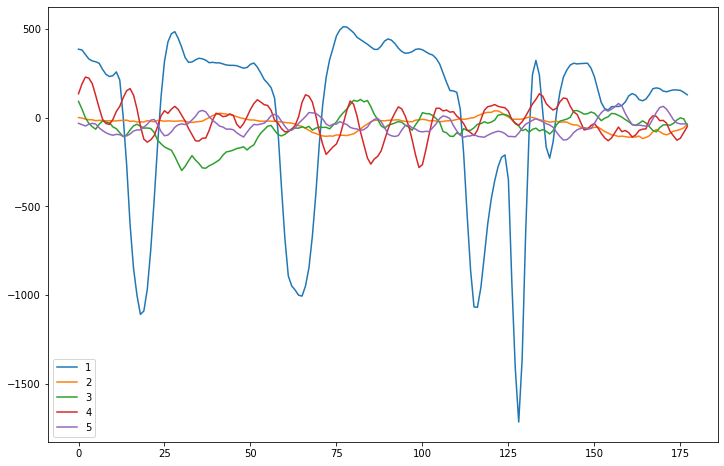

In [7]:
plt.figure(figsize=(12,8))
plt.plot(X[1,:],label='1')
plt.plot(X[7,:],label='2')
plt.plot(X[12,:],label='3')
plt.plot(X[0,:],label='4')
plt.plot(X[2,:],label='5')
plt.legend()
plt.show()

In [8]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = Sequential()
    model.add(LSTM(56, input_shape=(45,1), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(56))
    model.add(Dropout(0.3))
    model.add(Dense(20))
    model.add(Activation('tanh'))
    model.add(Dense(5))
    model.add(Activation('softmax'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(((X_train[:,::4]-X_train.mean())/X_train.std()),Y_train[:,1:],validation_data=((X_test[:,::4]-X_test.mean())/X_test.std(),Y_test[:,1:])
                ,epochs = 50, batch_size=15,shuffle=False
                )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45, 56)            12992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 56)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 56)                25312     
_________________________________________________________________
dropout_2 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1140      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

9200/9200 [==============================] - 39s 4ms/step - loss: 0.1645 - accuracy: 0.9202 - val_loss: 0.2176 - val_accuracy: 0.8990
Epoch 48/50
9200/9200 [==============================] - 39s 4ms/step - loss: 0.1629 - accuracy: 0.9194 - val_loss: 0.2222 - val_accuracy: 0.8966
Epoch 49/50
9200/9200 [==============================] - 39s 4ms/step - loss: 0.1611 - accuracy: 0.9228 - val_loss: 0.2145 - val_accuracy: 0.8994
Epoch 50/50
9200/9200 [==============================] - 39s 4ms/step - loss: 0.1611 - accuracy: 0.9225 - val_loss: 0.2246 - val_accuracy: 0.8974


In [9]:
model.save('Epilepsy.h5')


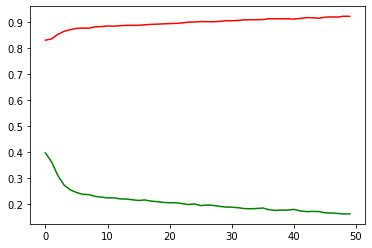

In [10]:
plt.figure(0)
plt.plot(hist.history['loss'],'g')
plt.plot(hist.history['accuracy'],'r')
plt.show()

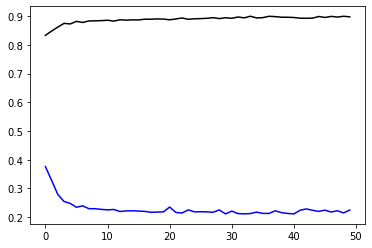

In [11]:
plt.figure(0)
plt.plot(hist.history['val_loss'],'b')
plt.plot(hist.history['val_accuracy'],'black')
plt.show()

In [12]:
from keras.models import load_model
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation , LSTM , Dropout , AveragePooling3D
import pandas as pd

import matplotlib.pyplot as plt

In [13]:
model = load_model('Epilepsy.h5')

In [14]:
ypred=model.predict((X_test[:,::4]-X_test.mean())/X_test.std())
ypred.shape

(2300, 5)

In [15]:
print(ypred)


[[2.9210087e-05 2.4592143e-01 6.3394219e-01 1.3412105e-02 1.0669508e-01]
 [9.9992967e-01 1.9002628e-05 6.4768033e-06 3.8992795e-05 5.9225758e-06]
 [9.9966037e-01 1.7148578e-04 9.7255703e-05 5.7649027e-05 1.3240739e-05]
 ...
 [9.9992323e-01 1.8917108e-05 5.9565691e-06 4.4940192e-05 6.9248681e-06]
 [2.0965603e-04 7.1220130e-01 2.8603724e-01 2.3208820e-04 1.3197600e-03]
 [4.5815377e-05 8.1991285e-01 1.3701655e-01 5.3175031e-03 3.7707184e-02]]


In [16]:
yp=np.zeros((Y_test.shape[0]))
yo=np.ones((Y_test.shape[0]))

In [18]:
for i in range(Y_test.shape[0]):
    yp[i]=np.argmax(ypred[i])+1
    yo[i]=np.argmax(Y_test[i])

In [19]:
yp.shape

(2300,)

In [20]:
yo.shape

(2300,)

In [21]:
np.unique(yo)
np.unique(yp)

array([1., 2., 3., 4., 5.])

In [23]:
#conversion of classes
for i in range(Y_test.shape[0]):
    if yo[i]!=1:
        yo[i]=0
    if yp[i]!=1:
        yp[i]=0


In [24]:
np.unique(yo)
np.unique(yp)

array([0., 1.])

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(yo,yp)

0.9908695652173913